# Analyse Hookean model


In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

## Datasets selection

In [2]:
# Name: file
dataset_files = {
    'random_0_n100': 'outputs/Hookean/random_0_n100.npz',
    'random_1_n100': 'outputs/Hookean/random_1_n100.npz',
    'random_2_n100': 'outputs/Hookean/random_2_n100.npz'
}

In [3]:
# Load data
dataset = {}
for name, file in dataset_files.items():
    with np.load(file) as data:
        temp = dict(data)
        # Rename variables
        temp['S'] = temp.pop('S_average')
        temp['A'] = temp.pop('A_average')
        temp['∇U'] = temp.pop('gradU')
        # Add transposed variables
        
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        # Save
        dataset[name] = temp

## Make library of features

Matrix libraries will take data in the form of a dictionary and access the variables using their name. Therefore we need to specify which names we want to involve in the library by defining `variable_names`. Another useful parameter is the `transpose_map` dictionary where we write information about the transpose of the variables. In this dictionary, a key is a variable name of the dataset, and the value is:
- Same name if the variable is symmetric;
- Same name with a leading `-` if the variable is skew;
- The name of the transpose if it is present in the dataset;
- `None` otherwise.

Here we will be using the stress `'S'` which is symmetric, and both the velocity gradient `'∇U'` and its transposed `'∇Uᵀ'`.

In [4]:
variable_names = {'S', '∇U', '∇Uᵀ'}
transpose_map = {'S':'S', '∇U':'∇Uᵀ', '∇Uᵀ':'∇U'}

Now we can create a new library containing polynomial terms by calling `from_polynomial_matrices`. We need to provide: 
1. `n_terms`: number of mutliplication terms.
2. `intercept`: include the identity matrix as a feature.
3. `symmetry`: symmetry property of the feature. Here we want only symmetric features.

In [5]:
library = FeatureLibrary.from_polynomial_matrices(variable_names=variable_names, 
                                                  transpose_map=transpose_map, 
                                                  n_terms=4, intercept=True, symmetry='symmetric')
#library

We will also make a scalar library which returns the trace of these polynomial terms. Note that trivially equal features have been removed.

In [6]:
library_trace = FeatureLibrary.from_polynomial_traces(variable_names, transpose_map, n_terms=4, intercept=False)
#library_trace

Before we go on, we will remove `tr(∇U)` from the library as we expect this should be null from imcompressibility assumption.

In [7]:
library_trace.remove_by_name('tr(∇U)')

Type of feature output: scalar
Variables names: {'S', '∇Uᵀ', '∇U'}
Variables transpose map: {'S': 'S', '∇U': '∇Uᵀ', '∇Uᵀ': '∇U'}
Number of feature_functions: 27
(0)	tr(S)
(1)	tr(S∘S)
(2)	tr(S∘∇U)
(3)	tr(∇U∘∇U)
(4)	tr(∇U∘∇Uᵀ)
(5)	tr(S∘S∘S)
(6)	tr(S∘S∘∇U)
(7)	tr(S∘∇U∘∇U)
(8)	tr(S∘∇U∘∇Uᵀ)
(9)	tr(S∘∇Uᵀ∘∇U)
(10)	tr(∇U∘∇U∘∇U)
(11)	tr(∇U∘∇U∘∇Uᵀ)
(12)	tr(S∘S∘S∘S)
(13)	tr(S∘S∘S∘∇U)
(14)	tr(S∘S∘∇U∘∇U)
(15)	tr(S∘S∘∇U∘∇Uᵀ)
(16)	tr(S∘S∘∇Uᵀ∘∇U)
(17)	tr(S∘∇U∘S∘∇U)
(18)	tr(S∘∇U∘S∘∇Uᵀ)
(19)	tr(S∘∇U∘∇U∘∇U)
(20)	tr(S∘∇U∘∇U∘∇Uᵀ)
(21)	tr(S∘∇U∘∇Uᵀ∘∇U)
(22)	tr(S∘∇Uᵀ∘∇U∘∇U)
(23)	tr(∇U∘∇U∘∇U∘∇U)
(24)	tr(∇U∘∇U∘∇U∘∇Uᵀ)
(25)	tr(∇U∘∇U∘∇Uᵀ∘∇Uᵀ)
(26)	tr(∇U∘∇Uᵀ∘∇U∘∇Uᵀ)

Next we will further increase the complexity by 'tensorifying' the library with itself.

In [8]:
library_trace = library_trace + library_trace*library_trace
#library_trace

Now it is time to combine our matrix library and scalar library.

In [9]:
library = library + library_trace*library
len(library)

52233

We end up with a gigantic library we certainly want to trim, so we do by specifying the maximum degree in each variable:

In [10]:
library.trim({'S':2, '∇U':1, '∇Uᵀ':1})

Type of feature output: matrix
Symmetry of features: symmetric
Variables names: {'S', '∇Uᵀ', '∇U'}
Variables transpose map: {'S': 'S', '∇U': '∇Uᵀ', '∇Uᵀ': '∇U'}
Number of feature_functions: 68
(0)	I
(1)	S
(2)	∇U + (∇U)ᵀ
(3)	S∘S
(4)	S∘∇U + (S∘∇U)ᵀ
(5)	S∘∇Uᵀ + (S∘∇Uᵀ)ᵀ
(6)	∇U∘∇Uᵀ
(7)	∇Uᵀ∘∇U
(8)	S∘S∘∇U + (S∘S∘∇U)ᵀ
(9)	S∘S∘∇Uᵀ + (S∘S∘∇Uᵀ)ᵀ
(10)	S∘∇U∘S + (S∘∇U∘S)ᵀ
(11)	S∘∇U∘∇Uᵀ + (S∘∇U∘∇Uᵀ)ᵀ
(12)	S∘∇Uᵀ∘∇U + (S∘∇Uᵀ∘∇U)ᵀ
(13)	∇U∘S∘∇Uᵀ
(14)	∇Uᵀ∘S∘∇U
(15)	S∘S∘∇U∘∇Uᵀ + (S∘S∘∇U∘∇Uᵀ)ᵀ
(16)	S∘S∘∇Uᵀ∘∇U + (S∘S∘∇Uᵀ∘∇U)ᵀ
(17)	S∘∇U∘S∘∇Uᵀ + (S∘∇U∘S∘∇Uᵀ)ᵀ
(18)	S∘∇U∘∇Uᵀ∘S
(19)	S∘∇Uᵀ∘S∘∇U + (S∘∇Uᵀ∘S∘∇U)ᵀ
(20)	S∘∇Uᵀ∘∇U∘S
(21)	∇U∘S∘S∘∇Uᵀ
(22)	∇Uᵀ∘S∘S∘∇U
(23)	tr(S)I
(24)	tr(S)S
(25)	tr(S)(∇U + (∇U)ᵀ)
(26)	tr(S)(S∘∇U + (S∘∇U)ᵀ)
(27)	tr(S)(S∘∇Uᵀ + (S∘∇Uᵀ)ᵀ)
(28)	tr(S)∇U∘∇Uᵀ
(29)	tr(S)∇Uᵀ∘∇U
(30)	tr(S)(S∘∇U∘∇Uᵀ + (S∘∇U∘∇Uᵀ)ᵀ)
(31)	tr(S)(S∘∇Uᵀ∘∇U + (S∘∇Uᵀ∘∇U)ᵀ)
(32)	tr(S)∇U∘S∘∇Uᵀ
(33)	tr(S)∇Uᵀ∘S∘∇U
(34)	tr(S∘S)I
(35)	tr(S∘S)(∇U + (∇U)ᵀ)
(36)	tr(S∘S)∇U∘∇Uᵀ
(37)	tr(S∘S)∇Uᵀ∘∇U
(38)	tr(S∘∇U)I
(39)	tr(S∘∇U)S
(40)	tr(S∘

## Evaluate strong-form features

For each scenario in the dataset, we evalulate the features from the original (noisy) data and store them in a list. These are features that would be used in a direct application of SINDy.

In [11]:
precursor_dict = {}
for scenario, data in dataset.items():
    precursors = []
    for feature in library.feature_functions:
        precursors.append(feature(data))
    precursor_dict[scenario] = precursors

In [12]:
def inspect(scenario, line, feature):

    ln = ['x', 'y', 'z']
    plt.plot(dataset[scenario]['t'], precursor_dict[scenario][feature][:,line,0], c='#0c2c84', linewidth=2, label=f'{ln[line]}x')
    plt.plot(dataset[scenario]['t'], precursor_dict[scenario][feature][:,line,1], c='#1d91c0', linewidth=2, label=f'{ln[line]}y')
    plt.plot(dataset[scenario]['t'], precursor_dict[scenario][feature][:,line,2], c='#7fcdbb', linewidth=2, label=f'{ln[line]}z')
    plt.legend()
    
    plt.show()


w = interactive(inspect, scenario=widgets.Dropdown(
                    options=list(precursor_dict.keys()),
                    value=next(iter(precursor_dict.keys())),
                    description='Scenario:',
                    disabled=False,
                    ),
                    line=widgets.Dropdown(
                    options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                    value=0,
                    description='Line:',
                    disabled=False,
                    ),
                    feature=widgets.Dropdown(
                    options=list(zip(library.feature_names, range(len(library)))),
                    value=0,
                    description='Feature precursor:',
                    disabled=False,
                    )
               )
w

interactive(children=(Dropdown(description='Scenario:', options=('random_0_n100', 'random_1_n100', 'random_2_n…

## Make weak-form features

From the literature, weak-form SINDy is more resilient to noisy data. The weak form is simply achieved by projection (weighted sum in our case) onto test functions. Here, we call the test functions *windows*, refering to signal processing. Sampling the weak-form problem is then, for each window, projecting the stress or conformtation tensor onto `diff(window)` and feature onto `window`, where `diff` is a finite differenciation function. In this descrete setting, the strong-form problem with Euler scheme is actually a special case where `window = [0, 1, 0]` and `diff(window) = [0, -1, 1]`.

A few important remarks:

1. Using windows with a larger support acts as a low-pass filter on the features. However, as pointed out by [REF], features are evaluated before this filtering occurs, so that no assumption is made on the smoothness of the origninal data.

2. It is not obvious which window shape we should use. Some are better at filtering out high frequencies but is this really what matters? In our case, we don't know much about the properties of the noise. For example, using a rectangular window is not the best choice for noise, but it brings the problem closer to what we ultimately want to do: evaluate the stress (and not the rate of change, which is only a proxy). Applying a rectangular window is like integrating the data over chunks of time, producing an appraoch similar to that of Hayden Schaeffer and Scott G. McCalla, https://doi.org/10.1103/PhysRevE.96.023302, but avoiding drift.

3. We don't go into the complications of optimal window placement, which is a data selection process after all. At this point, we are still agnostic about the information content of the data, and we make the following choice: for a given window size, windows are distributed to cover the entire data but don't overlap (some data points at the end of the simulated scenario may be excluded). Therefore this approach is equivalent to a low-pass filtering followed by subsampling (in signal processing sense): if we choose a window size greater than one, we end up with less data in the weak form. Now, we can do this process with different window sizes and shapes, and regenerate as many weak-form data points as we want.

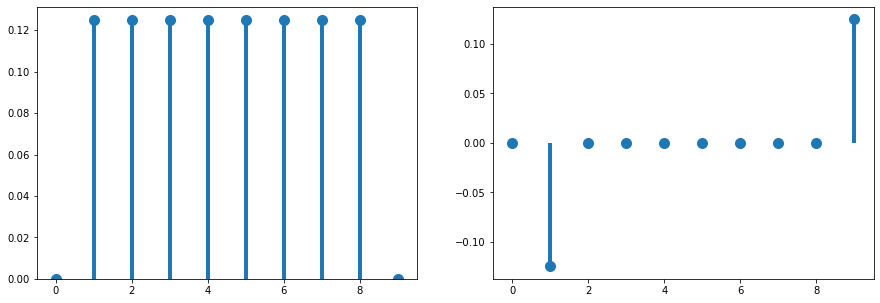

In [13]:
from matsindy.weak import make_window

window = make_window(10, 'rectangular')

width = len(window)
x = np.arange(width)
#print(window)
wind_diff = np.zeros(width)
# derivative: 
wind_diff[1:] = -np.diff(window)
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=2)
ax[0].bar(x, window, width=0.01*width)
ax[0].plot(window,'o',markersize=10)
ax[1].bar(x, wind_diff, width=0.01*width)
ax[1].plot(wind_diff,'o',markersize=10)
plt.show()

In [14]:
from matsindy.weak import weak_diff

weak_dataset_y = {}
for scenario, data in dataset.items():
    dt = data['t'][1]-data['t'][0]  # Assuming uniform time-step
    weak_dataset_y[scenario] = weak_diff(data['S'], dt, window)

In [15]:
from matsindy.weak import weak_form

weak_dataset_X = {}
for scenario, features in precursor_dict.items():
    weak_dataset_X[scenario] = [weak_form(feature, dt, window) for feature in features]

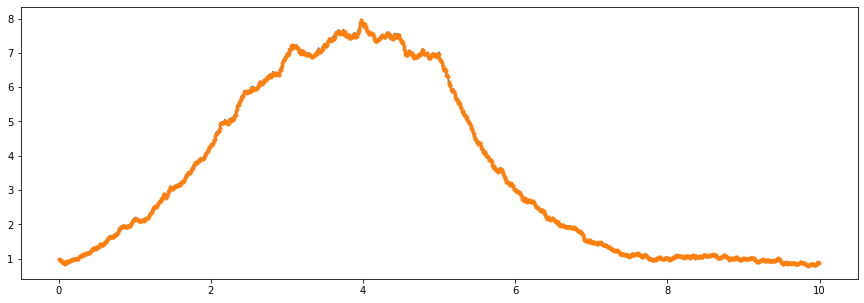

In [16]:
scenario = 'random_0_n100'
plt.plot(dataset[scenario]['t'], dataset[scenario]['S'][:,0,0])
plt.plot(dataset[scenario]['t'][width//2:-width//2:width-2], weak_dataset_X[scenario][1][:,0,0]/dt, '.')
plt.show()

## Assemble matrix before regression 

Note: at this point, time differentiation has already been done, so the order of data points doesn't matter.

In [17]:
y = np.hstack([weak_dataset_y[scenario].flatten() for scenario in dataset.keys()])

In [18]:
y.shape

(33723,)

In [19]:
Xs = []
for scenario in dataset.keys():
    flat_features = [feature.flatten() for feature in weak_dataset_X[scenario]]
    X = np.array(flat_features)
    Xs.append(X.T)

In [20]:
X = np.vstack(Xs)

In [21]:
X.shape

(33723, 68)

## Regression

In [22]:
from matsindy.optimizer import SSR

In [23]:
models = SSR(X,y)

In [24]:
models[-4].print(library)

Number of active terms: 4
(0)	+0.9581 I
(1)	-1.0269 S
(4)	+1.0321 S∘∇U + (S∘∇U)ᵀ
(38)	+0.0111 tr(S∘∇U)I


In [25]:
errors = [model.error for model in models]
num_terms = [model.num_terms for model in models]

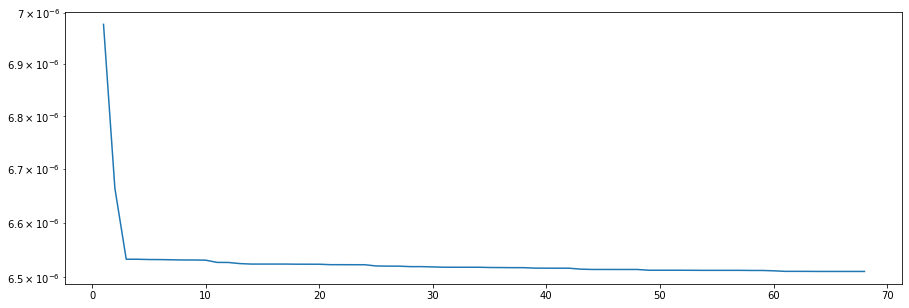

In [26]:
plt.semilogy(num_terms, errors)

In [27]:
type(models[0])

matsindy.model.model

In [28]:
type(0.2)

float

In [30]:
from matsindy.optimizer import bagging_SSR

bagging_SSR(X, y, n_estimators=10, n_samples=5000)